In [1]:
import sys
sys.path.append('/home/jgould/Documents/AdaptiveLatents/tests')
from test_speed import get_speed_over_time

import adaptive_latents as al
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import h5py


In [3]:
al.CONFIG['data_path'] / 'Chestek' / 'first_extraction.mat'

PosixPath('/home/jgould/Documents/Bubblewrap/generated/datasets/Chestek/first_extraction.mat')

In [8]:
mat = loadmat(al.CONFIG['data_path'] / 'Chestek' / 'jgould_first_extraction.mat', squeeze_me=True, simplify_cells=True)
pre_smooth_beh = mat["feats"][1]
pre_smooth_A = mat["feats"][0]
pre_smooth_t = mat["feats"][2] / 1000

pre_smooth_beh = pre_smooth_beh.reshape((pre_smooth_beh.shape[0], 3, 5))

nonzero_columns = pre_smooth_beh.std(axis=0) > 0
assert np.all(~(nonzero_columns[0,:] ^ nonzero_columns)) # checks that fingers always have the same values
pre_smooth_beh = pre_smooth_beh[:,:,nonzero_columns[0,:]] # the booleans select for position, velocity, and acceleration
pre_smooth_beh = pre_smooth_beh[:, [True, False, False], :].reshape(pre_smooth_beh.shape[0], -1) # the three booleans select for position, velocity, and acceleration

mode = 'valid'
kernel = np.exp(np.linspace(0,-1,5))
kernel /= kernel.sum()

pre_prosvd_A = np.column_stack([np.convolve(kernel, column, mode) for column in pre_smooth_A.T])
pre_prosvd_t = np.convolve(np.hstack([[1],kernel[:-1]*0]), pre_smooth_t, mode)
pre_prosvd_beh = pre_smooth_beh

pre_prosvd_A = al.transforms.utils.center_from_first_n(pre_prosvd_A, 100)
pre_prosvd_A, pre_prosvd_beh, pre_prosvd_t = al.transforms.utils.clip(pre_prosvd_A, pre_prosvd_beh, pre_prosvd_t)

pre_jpca_A, Qs = al.transforms.utils.prosvd_data_with_Qs(pre_prosvd_A, 4, 50)
pre_jpca_A, pre_jpca_t, pre_jpca_beh = al.transforms.utils.clip(pre_jpca_A, pre_prosvd_t, pre_prosvd_beh)

A, beh, t = pre_jpca_A, pre_jpca_beh, pre_jpca_t

In [9]:
times_dict = get_speed_over_time(pre_prosvd_A, pre_prosvd_beh, bw_params=dict(num=1000), max_steps=2000)

In [10]:
keys = list(times_dict.keys())
times = np.array([times_dict[k] for k in keys])*1000

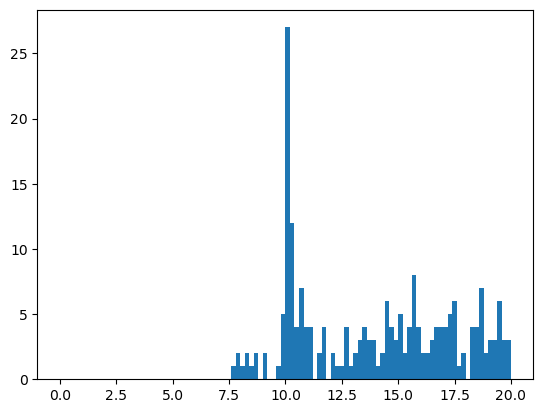

In [11]:
plt.hist(times.sum(axis=0), np.linspace(0,20,101));

Text(0, 0.5, 'iteration time (ms)')

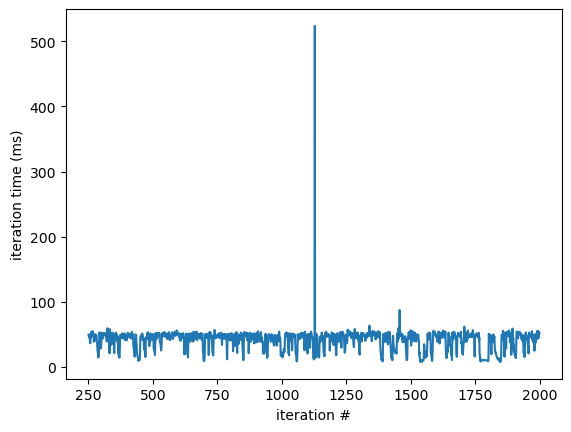

In [12]:
fig, ax = plt.subplots()
slice_start = 250
good_slice = times.sum(axis=0)[slice_start:]
ax.plot(np.arange(len(good_slice))+slice_start, good_slice)
ax.set_xlabel("iteration #");
ax.set_ylabel("iteration time (ms)")

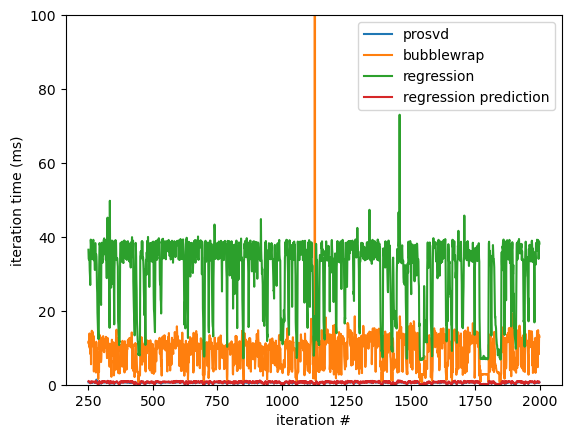

In [15]:
fig, ax = plt.subplots()
slice_start = 250
good_slice = times[:,slice_start:]
ax.plot(np.arange(good_slice.shape[1])+slice_start, good_slice.T, label=keys)
ax.set_xlabel("iteration #");
ax.set_ylabel("iteration time (ms)")
ax.set_ylim([0,100])
ax.legend();